## Analyzer for Elisa's 3P1F and 2P2F event lists and for CJLST NTuples.

In [3]:
# Execute `voms-proxy-init` in the shell before starting this JupyNB.
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from collections import Counter

import uproot
import pandas as pd

top_dir = "/blue/avery/rosedj1/"
# sys.path.append(top_dir)

# top_dir = "/afs/cern.ch/work/d/drosenzw/zplusx/"
_ = [sys.path.append(os.path.join(top_dir, package)) for package in ("HiggsMassMeasurement", "ZplusXpython")]
# from Utils_Python.Utils_Files import check_overwrite
from sidequests.data.cjlst_fw import CjlstFlag
from Utils_Python.Commands import shell_cmd
from Utils_Python.Utils_Files import save_to_json, open_json

In [ ]:
infile_matteo_data2018 = "/eos/cms/store/group/phys_higgs/cmshzz4l/cjlst/RunIILegacy/200430_LegacyRun2/Data_2018/AllData/ZZ4lAnalysis.root"
t_matteo_up = uproot.open(f"root://eoscms.cern.ch/{infile_matteo_data2018}:CRZLLTree/candTree", timeout=180)

runnum_arr = t_matteo_up["RunNumber"].array(library="np")

In [39]:
def write_tree_info_to_txt(infile, outtxt, keep_2P2F=True, keep_3P1F=True):
    """
    Write info from TFile `infile` from TTree 'passedEvents' to `outtxt`.

    Info which gets written:
    Run : LumiSect : Event
    """
    tfile = rt.TFile.Open(infile)
    tree = tfile.Get("passedEvents")

    with open(outtxt, "w") as f:
        f.write("# Run : LumiSect : Event\n")
        for evt in tree:
            keep_evt = True if (keep_2P2F and evt.is2P2F) or (keep_3P1F and evt.is3P1F) else False
            if keep_evt:
                f.write(f"{evt.Run} : {evt.LumiSect} : {evt.Event}\n")
    print(f"TTree info written to:\n{outtxt}")
 
def get_list_of_lines(evt_ls_txt):
    """
    Return a list of the lines from `evt_ls_txt`.
    The lines must start with a digit.
    Trailing newlines ('\\n') are stripped.
    """
    with open(evt_ls_txt, "r") as f:
        return [line.rstrip('\n') for line in f.readlines() if line[0].isdigit()]

def get_list_of_tuples(evt_ls):
    """
    Return a list of 3-tuples from a list of strings `evt_ls`:

    [
        (Run1, LumiSect1, Event1),
        (Run2, LumiSect2, Event2),
        ...
    ]
    """
    new_evt_ls = []
    for line in evt_ls:
        tup = tuple([int(num) for num in line.split(":")[:3]])
        new_evt_ls.append(tup)
    return new_evt_ls

def print_evt_info_bbf(tree):
    print(f"tree.passedFullSelection: {tree.passedFullSelection}")
    print(f"tree.passedZXCRSelection: {tree.passedZXCRSelection}")
    print(f"tree.nZXCRFailedLeptons: {tree.nZXCRFailedLeptons}")
    print(f"tree.lep_Hindex: {list(tree.lep_Hindex)}")
    print(f"tree.lepFSR_pt: {list(tree.lepFSR_pt)}")
    print(f"tree.lep_RelIso: {list(tree.lep_RelIso)}")
    print(f"tree.lep_id: {list(tree.lep_id)}")
    print(f"tree.lep_tightId: {list(tree.lep_tightId)}")
    print("#--- PRINT MORE Z AND H INFO HERE. ---#")

def print_evt_info_cjlst(tree):
    print(f"tree.LepPt: {list(tree.LepPt)}")
    print(f"tree.LepLepId: {list(tree.LepLepId)}")
    print(f"tree.LepisID (tight lep): {list(np.array(tree.LepisID, dtype=bool))}")
    print(f"tree.LepisID (tight lep): {list(np.array(tree.LepisID, dtype=bool))}")
    print(f"tree.CRflag: {tree.CRflag} -> {CjlstFlag(tree.CRflag).name}")
    print(f"tree.Z1Mass: {tree.Z1Mass}")
    print(f"tree.Z2Mass: {tree.Z2Mass}")
    print(f"tree.ZZMass: {tree.ZZMass}")
    print()

def analyze_single_evt(tree, run, lumi, event, fw="bbf", which="all", evt_start=0, print_every=10000):
    """Print out event info (`run`:`lumi`:`event`) found in `tree`.
    
    Parameters
    ----------
    fw : str
        Which framework to use: "bbf", "cjlst"
    which : str
        Which instance of the event you want to select.
        Options: "first", anything else prints all such events.
    evt_start : int
    """
    print(f"Searching for event ID {run}:{lumi}:{event} in {fw.upper()} framework")

    n_tot = tree.GetEntries()
    for evt_num in range(evt_start, n_tot):
        tree.GetEntry(evt_num)
        if (evt_num % print_every) == 0:
            print(f"Event {evt_num}/{n_tot}")

        if fw in "bbf":
            if tree.Run != run:
                continue
            if tree.LumiSect != lumi:
                continue
            if tree.Event != event:
                continue
            if not tree.passedZXCRSelection:
                print(f"[WARNING] Event has passedZXCRSelection == 0.")
            print(f"Event {run}:{lumi}:{event} found. Index: {evt_num}")
            print_evt_info_bbf(tree)

        elif fw in "cjlst":
            if tree.RunNumber != run:
                continue
            if tree.LumiNumber != lumi:
                continue
            if tree.EventNumber != event:
                continue
            print(f"Event {run}:{lumi}:{event} found. Index: {evt_num}")
            print_evt_info_cjlst(tree)

        if "first" in which:
            break
    print("Done.")

def get_control_region(evt):
    """Return str of control region based on `lep_Hindex` and `lep_tightId`.

    Only works for BBF root files.
    """
    l_Hindex_ls = list(evt.lep_Hindex)
    assert -1 not in l_Hindex_ls
    l_tightId_arr = np.array(evt.lep_tightId)[l_Hindex_ls]

    # 3P1F is defined as 3 leptons passing tight and ISO criteria:
    l_RelIsoNoFSR_arr = np.array(evt.lep_RelIsoNoFSR)[l_Hindex_ls]
    # muons_arr = 
    # l_RelIsoNoFSR_arr
    s = l_tightId_arr.sum()

    if s == 4:
        return "SR"
    elif s == 3:
        return "3P1F"
    elif s == 2:
        return "2P2F"
    else:
        return f"[WARNING] Could not assign number of tight leps ({s}) to a CR!"

In [5]:
class FileComparer:

    def __init__(self, txt_file1, txt_file2, control_reg="", verbose=False):
        """
        Feed in two txt files to be compared.

        NOTE:
        - Each txt file is converted to a list of 3-tuples and stored.
        - Only lines which begin with a digit are read and stored.

        Parameters
        ----------
        control_reg : str
            Used for printing and writing files.
        """
        self.file1 = txt_file1
        self.file2 = txt_file2
        self.cr = control_reg
        self.verbose = verbose

        self.check_cr(txt_file1, txt_file2)
        if control_reg in "":
            self.cr = "all"
        self.ls_of_tup_file1_nodup = None
        self.ls_of_tup_file2_nodup = None

        # Check for duplicates.
        self.ls_of_tup_file1 = get_list_of_tuples(get_list_of_lines(txt_file1))
        if self.check_for_dups(txt_file1, self.ls_of_tup_file1):
            # Remove duplicates by turning to a set and then back to list.
            self.ls_of_tup_file1_nodup = list(set(self.ls_of_tup_file1))
        else:
            self.ls_of_tup_file1_nodup = self.ls_of_tup_file1

        self.ls_of_tup_file2 = get_list_of_tuples(get_list_of_lines(txt_file2))
        if self.check_for_dups(txt_file2, self.ls_of_tup_file2):
            self.ls_of_tup_file2_nodup = list(set(self.ls_of_tup_file2))
        else:
            self.ls_of_tup_file2_nodup = self.ls_of_tup_file2

        self.compare_files()

    def check_for_dups(self, txt_file, ls_of_tup):
        """Return True and print info if duplicates within a file are found."""
        len_ls = len(ls_of_tup)
        len_set = len(set(ls_of_tup))
        if len_ls != len_set:
            n_dups = len_ls - len_set
            print(f"[WARNING] Duplicates ({n_dups}) found in file: {txt_file}")
            print(f"[WARNING] len(ls)={len_ls} != len(set)={len_set}")
            if self.verbose:
                # There's some counting error here...
                # I know there are 120 duplicates, but counter only finds 118.
                counter = Counter(ls_of_tup)
                print(f"Printing duplicates in file:\n{txt_file}")
                dup_key_ls = [k for k,v in counter.items() if v > 1]
                # pprint(dup_key_ls)
                # assert n_dups == len(dup_key_ls)
                pprint(dup_key_ls)
            return True
        return False

    def check_cr(self, path1, path2):
        """Make sure that the control region is the one requested."""
        cr_low = self.cr.lower()
        assert cr_low in ("2p2f", "3p1f", "")
        # Make sure that the two files have the requested CR.
        msg = f"The `control_reg` ({self.cr}) not found in names of txt files."
        assert all(cr_low in f.lower() for f in (path1, path2)), msg

    def compare_files(self):
        """Store unique and common info about files. Called when instantiated."""
        self.set_common_to_both = set(self.ls_of_tup_file1_nodup) & set(self.ls_of_tup_file2_nodup)
        self.set_unique_to_file1 = set(self.ls_of_tup_file1_nodup) - set(self.ls_of_tup_file2_nodup)
        self.set_unique_to_file2 = set(self.ls_of_tup_file2_nodup) - set(self.ls_of_tup_file1_nodup)

    def print_results(self, whose="all", show_n_evts=25, save_to_file=None):
        """Print info describing differences between two files.
        
        Parameters
        ----------
        whose : str
            "file1", "file2", "all"
        """
        print(f"Comparing {self.cr.upper()}:")
        print(f"file1: {self.file1}")
        print(f"file2: {self.file2}")

        print(f"{'n_evts total file1 (no dup): ':<25}{len(self.ls_of_tup_file1_nodup)}")
        print(f"{'n_evts total file2 (no dup): ':<25}{len(self.ls_of_tup_file2_nodup)}")
        print(f"{'n_evts in common: ':<25}{len(self.set_common_to_both)}")
        print(f"{'n_evts unique to file1: ':<25}{len(self.set_unique_to_file1)}")
        print(f"{'n_evts unique to file2: ':<25}{len(self.set_unique_to_file2)}")

        header = "#-- Run -- LumiSect -- Event --#"
        if show_n_evts == -1:
            show_n_evts = None
        if whose in ("file1", "all"):
            print(f"  file1's unique events:")
            print(header)
            pprint(list(self.set_unique_to_file1)[:show_n_evts])
            print()
        if whose in ("file2", "all"):
            print(f"  file2's unique events:")
            print(header)
            pprint(list(self.set_unique_to_file2)[:show_n_evts])
            print()

    def save_events_to_txt(self, kind, outtxt, no_dup=True, overwrite=False):
        """
        Write the events to `outtxt` in the format:

        Run : LumiSect : Event

        Parameters
        ----------
        kind : str
            Choose which events to write to `outtxt`.
            "file1", "file2", "common", "file1_unique", "file2_unique"
        """
        check_overwrite(outtxt, overwrite=overwrite)
        assert kind in ("file1", "file2", "common", "file1_unique", "file2_unique")

        if kind in "file1":
            iter_ls_of_tup = self.ls_of_tup_file1_nodup if no_dup else self.ls_of_tup_file1
        elif kind in "file2":
            iter_ls_of_tup = self.ls_of_tup_file2_nodup if no_dup else self.ls_of_tup_file2
        elif kind in "common":
            iter_ls_of_tup = self.set_common_to_both
        elif kind in "file1_unique":
            iter_ls_of_tup = self.set_unique_to_file1
        elif kind in "file2_unique":
            iter_ls_of_tup = self.set_unique_to_file2

        with open(outtxt, "w") as f:
            f.write("# Run : LumiSect : Event\n")
            for tup in iter_ls_of_tup:
                f.write(f"{tup[0]} : {tup[1]} : {tup[2]}\n")
            print(f"Wrote '{self.cr} {kind}' events to file:\n{outtxt}")

In [2]:
# infile_jake_tree = "/blue/avery/rosedj1/ZplusXpython/data/ZLL_CR_FRapplied/Data_2018_NoDuplicates_RunEventLumi.root"
infile_jake_tree = "/blue/avery/rosedj1/ZplusXpython/data/ZLL_CR_FRapplied/new_data2018/cr_ZLL.root"
# ^Contains all the passedZXCRSelection events as in:
# /fullstats/ZL_ZLL_4P_CR/noduplicates/Data2018_NoDuplicates.root

#####################
#--- CJLST files ---#
#####################
infile_elisa       = "/blue/avery/rosedj1/ZplusXpython/sidequests/findmissingevents_comparetoelisa/CRLLos_listOfEvents.txt"
infile_elisa_2p2f  = "/blue/avery/rosedj1/ZplusXpython/sidequests/findmissingevents_comparetoelisa/CRLLos_2P2F_listOfEvents.txt"
infile_elisa_3p1f  = "/blue/avery/rosedj1/ZplusXpython/sidequests/findmissingevents_comparetoelisa/CRLLos_3P1F_listOfEvents.txt"
infile_matteo_data2018 = "/eos/cms/store/group/phys_higgs/cmshzz4l/cjlst/RunIILegacy/200430_LegacyRun2/Data_2018/AllData/ZZ4lAnalysis.root"
infile_cjlst_sr = "/blue/avery/rosedj1/ZplusXpython/sidequests/data/2018_CJLST_finalSelectedEvents_SR.txt"

elisa_3p1f_unique_evtid_dct_json = "/blue/avery/rosedj1/ZplusXpython/sidequests/findmissingevents_comparetoelisa/elisa_3p1f_unique_evtID_CR_dct.json"


outdir = "/blue/avery/rosedj1/ZplusXpython/sidequests/findmissingevents_comparetoelisa/jakes_new2018data/"

infile_jake      = os.path.join(outdir, "CRLLos_listOfEvents_jake.txt")
infile_jake_2p2f = os.path.join(outdir, "CRLLos_listOfEvents_jake_2P2F.txt")
infile_jake_3p1f = os.path.join(outdir, "CRLLos_listOfEvents_jake_3P1F.txt")
infile_elisa_unique_353 = "/blue/avery/rosedj1/ZplusXpython/sidequests/rootfiles/elisa_unique_353events.root"

outfile_elisa_2p2f_unique  = os.path.join(outdir, "CRLLos_2P2F_listOfEvents_unique.txt")
outfile_elisa_3p1f_unique  = os.path.join(outdir, "CRLLos_3P1F_listOfEvents_unique.txt")
outfile_jake_2p2f_unique = os.path.join(outdir, "CRLLos_listOfEvents_jake_2P2F_unique.txt")
outfile_jake_3p1f_unique = os.path.join(outdir, "CRLLos_listOfEvents_jake_3P1F_unique.txt")
outfile_LLR_data2018 = "/blue/avery/rosedj1/ZplusXpython/sidequests/findmissingevents_comparetoelisa/"

outfile_2p2f_common = os.path.join(outdir, "CRLLos_listOfEvents_2P2F_common.txt")
outfile_3p1f_common = os.path.join(outdir, "CRLLos_listOfEvents_3P1F_common.txt")
# write_tree_info_to_txt(infile_jake_tree, infile_jake)

## Make txt files of events.

In [ ]:
write_tree_info_to_txt(infile_jake_tree, infile_jake_2p2f, keep_2P2F=True, keep_3P1F=False)
write_tree_info_to_txt(infile_jake_tree, infile_jake_3p1f, keep_2P2F=False, keep_3P1F=True)

## Compare files.

In [ ]:
fc_elisa_2p2fvs3p1f = FileComparer(infile_elisa_2p2f, infile_elisa_3p1f)

In [ ]:
fc_jakevselisa_3p1f = FileComparer(infile_jake_3p1f, infile_elisa_3p1f, control_reg="3p1f", verbose=True)
fc_jakevselisa_2p2f = FileComparer(infile_jake_2p2f, infile_elisa_2p2f, control_reg="2p2f", verbose=True)
fc_jakevselisa_all  = FileComparer(infile_jake, infile_elisa, control_reg="", verbose=True)

# fc_jakevselisa_3p1f.print_results(whose="file1", show_n_evts=5)
# fc_jakevselisa_3p1f.print_results(whose="file2", show_n_evts=5)
# fc_jakevselisa_2p2f.print_results(whose="file1", show_n_evts=5)
# fc_jakevselisa_2p2f.print_results(whose="file2", show_n_evts=5)
# # fc_jakevselisa_all.print_results(whose="all", show_n_evts=10)

# # Write the events to txt.
# overwrite = 0
# fc_jakevselisa_3p1f.save_events_to_txt(kind="file1_unique", outtxt=outfile_jake_3p1f_unique, no_dup=True, overwrite=overwrite)
# fc_jakevselisa_3p1f.save_events_to_txt(kind="file2_unique", outtxt=outfile_elisa_3p1f_unique, no_dup=True, overwrite=overwrite)
# fc_jakevselisa_3p1f.save_events_to_txt(kind="common", outtxt=outfile_3p1f_common, no_dup=True, overwrite=overwrite)

# fc_jakevselisa_2p2f.save_events_to_txt(kind="file1_unique", outtxt=outfile_jake_2p2f_unique, no_dup=True, overwrite=overwrite)
# fc_jakevselisa_2p2f.save_events_to_txt(kind="file2_unique", outtxt=outfile_elisa_2p2f_unique, no_dup=True, overwrite=overwrite)
# fc_jakevselisa_2p2f.save_events_to_txt(kind="common", outtxt=outfile_2p2f_common, no_dup=True, overwrite=overwrite)

In [ ]:
len(fc_jakevselisa_all.ls_of_tup_file2) - len(fc_jakevselisa_all.ls_of_tup_file2_nodup)

In [ ]:
# Make a manual counter.
# Print out events which appear more than once in fc_jakevselisa_all.ls_of_tup_file2.
for f in fc_jakevselisa_all.ls_of_tup_file2:
    ct = 0
    if f in fc_jakevselisa_all.ls_of_tup_file2_nodup:
        if ct == 5: break
        print(f)
# Identify the 2 events from 120 which didn't appear in 118.
# Why did counter not find them?

## LLR Group's (diff. xs) RedBkg Files

Vukasin pointed me to their root files:

- `/afs/cern.ch/user/v/vmilosev/public/forJake/new_ZX_LLR/AllData*`

Let's have a look.

In [ ]:
infile_llr_2018 = "/blue/avery/rosedj1/ZplusXpython/sidequests/data/LLR_redbkg/AllData_ZX_redTree_2018.root"

f_llr = TFile(infile_llr_2018)
t_llr = f_llr.Get("SelectedTree")

odd_event = (315488, 152, 135937874, )

n_tot_evts = t_llr.GetEntries()
for evt_num, evt in enumerate(t_llr):
    if (evt_num % 500) == 0:
        print(f"Checking event #{evt_num}/{n_tot_evts}")
    if evt.RunNumber != odd_event[0]:
        continue
    if evt.LumiNumber != odd_event[1]:
        continue
    if evt.EventNumber != odd_event[2]:
        continue
    print(f"Event found ({evt.RunNumber}:{evt.LumiNumber}:{evt.EventNumber}) at index {evt_num}")
    break

In [ ]:
list(t.GetListOfBranches())

t.Scan("htxs_stage1_red_cat:htxs_stage1_red_catName:htxs_stage1_red_prod_cat:htxs_stage1_red_prod_catName")

#--- Counting instances of htxs_stage1 ---#
# htxs_stage1_red_catName_ls = [str(evt.htxs_stage1_red_catName) for evt in t if evt.htxs_stage1_red_catName == 'ZX']
# count_ZX_str = Counter(htxs_stage1_red_catName_ls)
htxs_stage1_red_cat_ls = [str(evt.htxs_stage1_red_cat) for evt in t if evt.htxs_stage1_red_cat == -2]
count_ZX_cat = Counter(htxs_stage1_red_cat_ls)
# dup_key_ls = [k for k,v in counter.items() if v > 1]
print(count_ZX_cat)

t.GetEntries()  # 12331

#--- Tried to match any of Elisa's ZLL events to diff. xs group's events.
#--- None matched.
elisa_evtid_2p2f_tup = get_list_of_tuples(get_list_of_lines(infile_elisa_2p2f))
n_tot_tup = len(elisa_evtid_2p2f_tup)
start_at = 1000
for num_tup, tup in enumerate(elisa_evtid_2p2f_tup[start_at:], start_at):
    if (num_tup % 1000) == 0:
        print(f"Checking tuple #{num_tup}/{n_tot_tup}")
    for evt_num, evt in enumerate(t):
        if evt.RunNumber != elisa_evtid_2p2f_tup_example[0]:
            continue
        if evt.LumiNumber != elisa_evtid_2p2f_tup_example[1]:
            continue
        if evt.EventNumber != elisa_evtid_2p2f_tup_example[2]:
            continue
        print(f"Event {evt_num}, {evt.RunNumber}:{evt.LumiNumber}:{evt.EventNumber}")
        break

## Conclusion

These are Diff. XS Group's SR samples.
They do not contain RedBkg info.

### So What Next?

Matteo gave me a CJLST 2018 Data NTuple to look at.

Let's have a look.

### Verify duplicate.


In [ ]:
# Count the number of 3P1F, 2P2F, and SS events in CJLST NTuples:
for c in CjlstFlag:
    conreg = c.name
    n = t_matteo.GetEntries(f"CRflag == {c}")
    print(f"Number of {conreg} entries: {n}")
# Output:
# Number of CR3P1F entries: 4806  (after removing duplicate -> 4805)
# Number of CR2P2F entries: 46067 (after removing duplicate -> 46066)
# Number of CRLLss entries: 50144
# I believe there is one duplicate in 3P1F and 2P2F:
# 315512 : 947 : 703286863

In [ ]:
# Building CJLST event analyzer.
dup = (315512, 947, 703286863)
ct = 0
dup_dict = {}
    for evt_num, evt in enumerate(t):
        if evt.RunNumber != :
            continue
        if evt.LumiNumber != :
            continue
        if evt.EventNumber != :
            continue
    ct += 1
    dup_dict[evt_num] = (evt.RunNumber, evt.LumiNumber, evt.EventNumber, evt.Z1Mass, evt.Z2Mass, evt.ZZMass,)
    if ct > 1:
        break 

In [ ]:
guinea_pig_tup = (315512, 947, 703286863, )
for evt_num, evt in enumerate(t_jake_2018data):
    if evt.Run != guinea_pig_tup[0]:
        continue
    if evt.LumiSect != guinea_pig_tup[1]:
        continue
    if evt.Event != guinea_pig_tup[2]:
        continue
    print(f"Event number {evt_num}.")
    print(f"lep_pt: {list(evt.lep_pt)}")
    print(f"lep_FSRpt: {list(evt.lep_FSRpt)}")
    break


# t_jake_2018data.GetEntry(660)
print(f"t_jake_2018data.lep_Hindex: {list(t_jake_2018data.lep_Hindex)}")
print(f"t_jake_2018data.lepFSR_pt: {list(t_jake_2018data.lepFSR_pt)}")
print(f"t_jake_2018data.lep_RelIso: {list(t_jake_2018data.lep_RelIso)}")
print(f"t_jake_2018data.lep_id: {list(t_jake_2018data.lep_id)}")
print(f"t_jake_2018data.lep_tightId: {list(t_jake_2018data.lep_tightId)}")
# print(f"t_jake_2018data.lep_tightId: {t_jake_2018data.lep_tightId}")
# print(f"t_jake_2018data.lep_RelIsoNoFSR: {t_jake_2018data.RelIsoNoFSR}")

# print(f"t_jake_2018data.lep_id: {t_jake_2018data.lep_id}")

t_jake_2018data.passedZXCRSelection
print(t_jake_2018data.Run)
print(t_jake_2018data.LumiSect)
print(t_jake_2018data.Event)

# elisa_unique_event_3p1f_325159_181_259586791.root
unique_3p1f_evt = (321973, 1133, 1973286739,)
for evt_num, evt in enumerate(t_jake_2018data):
    if evt.Run != unique_3p1f_evt[0]:
        continue
    if evt.LumiSect != unique_3p1f_evt[1]:
        continue
    if evt.Event != unique_3p1f_evt[2]:
        continue
    print(f"Event number {evt_num}.")
    print(f"lep_pt: {list(evt.lep_pt)}")
    print(f"lep_FSRpt: {list(evt.lep_FSRpt)}")
    break


In [3]:
from ROOT import TFile
f_matteo = TFile.Open(f"root://eoscms.cern.ch/{infile_matteo_data2018}")
t_matteo = f_matteo.Get("CRZLLTree/candTree")
print(f"File opened:\n{infile_matteo_data2018}")

f_jake = TFile.Open(infile_jake_tree)
t_jake = f_jake.Get("passedEvents")

f_elisa_353 = TFile(infile_elisa_unique_353)
t_elisa_353 = f_elisa_353.Get("Ana/passedEvents")

File opened:
/eos/cms/store/group/phys_higgs/cmshzz4l/cjlst/RunIILegacy/200430_LegacyRun2/Data_2018/AllData/ZZ4lAnalysis.root


### Make a `dict` (all CJLST eventIDs : CRs) and then look for Elisa's unique events.

- All of Elisa's events were (of course) found in the CJLST NTuple.

In [ ]:
n_tot_cjlst = t_matteo.GetEntries()
cjlst_evtid_dct = {}
for evt_num, evt in enumerate(t_matteo):
    if (evt_num % 5000) == 0:
        print(f"CJLST TTree at entry: {evt_num}/{n_tot_cjlst}")
    key = f"{evt.RunNumber} : {evt.LumiNumber} : {evt.EventNumber}"
    this_single_cr_ls = [CjlstFlag(evt.CRflag).name]
    if key not in cjlst_evtid_dct.keys():
        cjlst_evtid_dct[key] = this_single_cr_ls
    else:
        # Event with this Run:Lumi:Event has already been stored.
        # This entry contains a new CR (by combining different leptons).
        cjlst_evtid_dct[key].extend(this_single_cr_ls)

In [ ]:
import json
outfile = "/blue/avery/rosedj1/ZplusXpython/sidequests/findmissingevents_comparetoelisa/cjlst_evtID_CR_dct.json"

with open(outfile, 'w') as f:
    json.dump(cjlst_evtid_dct, f, indent=4, sort_keys=False)
print(f"[INFO] JSON file written:\n{outfile}\n")

In [2]:
cjlst_evtid_dct = open_json("/blue/avery/rosedj1/ZplusXpython/sidequests/findmissingevents_comparetoelisa/cjlst_evtID_CR_dct.json")

In [ ]:
# Make dict (Elisa's eventIDs : CRs).
elisa_3p1f_unique_ls_tup = get_list_of_tuples(get_list_of_lines(outfile_elisa_3p1f_unique))

n_tot_uniq = len(elisa_3p1f_unique_ls_tup)
n_tot_cjlst = t_matteo.GetEntries()
elisa_3p1f_unique_evtid_dct = {}

for unique_evt_num, evt_id in enumerate(elisa_3p1f_unique_ls_tup, 1):
    if (unique_evt_num % 100) == 0:
        print(f"Searching for Elisa's unique event {unique_evt_num}/{n_tot_uniq}: {evt_id}")
    elisa_key = f"{evt_id[0]} : {evt_id[1]} : {evt_id[2]}"
    elisa_3p1f_unique_evtid_dct[elisa_key] = cjlst_evtid_dct[elisa_key]

save_to_json(elisa_3p1f_unique_evtid_dct, elisa_3p1f_unique_evtid_dct_json, overwrite=False, sort_keys=False)

### Now study the properties of CJLST's unique 3P1F events:

In [ ]:
# Counter(elisa_3p1f_unique_evtid_dct.keys())
# list(elisa_3p1f_unique_evtid_dct.values())[:15]
ct = 0
for uniq_evtID, cr in elisa_3p1f_unique_evtid_dct.items():
    # if ("CR3P1F" in cr) and (len(cr) == 1):
    if "CR2P2F" in cr:
        print(f"eventID = {uniq_evtID}, CR = {cr}")
        ct += 1
print(ct)

### Do any of the unique events also belong to SR?

In [ ]:
#--- Make a dict(CJLST's SR eventID : CR) events. ---#
# cjlst_sr_ls_tup = get_list_of_tuples(get_list_of_lines(infile_cjlst_sr))
# cjlst_evtid_sr_dct = {k:['SR'] for k in cjlst_sr_ls_tup}


In [9]:
elisa_3p1f_unique_evtid_dct = open_json(elisa_3p1f_unique_evtid_dct_json)
elisa_3p1fonly_unique_ls = [k for k,v in elisa_3p1f_unique_evtid_dct.items() if len(v) == 1 and 'CR3P1F' in v]

# set(cjlst_evtid_sr_dct.keys()) & set()

In [14]:
# A few of Elisa's unique 3P1F events that belong to ONLY 3P1F:
elisa_3p1fonly_unique_ls[:4]

['321973 : 1133 : 1973286739',
 '321834 : 84 : 126135620',
 '320821 : 118 : 130885195',
 '316766 : 179 : 208365005']

In [12]:
# t_elisa_353 = BBF TTree, edmPickEvents on all of Elisa's unique 3P1F events.
analyze_single_evt(t_elisa_353, 321973, 1133, 1973286739, fw="bbf", which="all", evt_start=0, print_every=1000)

Searching for event ID 321973:1133:1973286739 in BBF framework
Event 0/353
Done.


In [25]:
# analyze_single_evt(t_elisa_353, run, lumi, event, fw="bbf", which="all", evt_start=0, print_every=1000)
analyze_single_evt(t_elisa_353, 321973, 1133, 1973286739, fw="cjlst", which="all", evt_start=0, print_every=10000)

In [26]:
elisa_3p1fonly_unique_set

[(321973, 1133, 1973286739),
 (321834, 84, 126135620),
 (316766, 179, 208365005),
 (320821, 118, 130885195)]

In [23]:
set(elisa_3p1fonly_unique_ls)

['324245 : 1579 : 2934965254',
 '321414 : 603 : 1034233936',
 '321990 : 164 : 299221432']

In [30]:
t_elisa_353_evtls = [(evt.Run, evt.LumiSect, evt.Event, ) for evt in t_elisa_353]
set_elisa_353_evt = set(t_elisa_353_evtls)

In [ ]:
elisa_3p1fonly_unique_set = set()
for evtid in elisa_3p1fonly_unique_ls:
    str_ls = evtid.split(":")
    str_ls = [s.rstrip().lstrip() for s in str_ls]
    run = int(str_ls[0])
    lumi = int(str_ls[1])
    event = int(str_ls[2])
    elisa_3p1fonly_unique_set.add((run, lumi, event, ))

In [43]:
ntrsct_353evt_and_elisa3p1fonlyunique_ls = list(set_elisa_353_evt & elisa_3p1fonly_unique_set)
ntrsct_353evt_and_elisa3p1fonlyunique_ls[:5]

[(322430, 331, 543297179),
 (325159, 181, 259586791),
 (320038, 81, 76284361),
 (324201, 414, 808176523),
 (322204, 866, 1544245921)]

In [44]:
len(ntrsct_353evt_and_elisa3p1fonlyunique_ls)

236

In [ ]:
analyze_single_evt(t_matteo, 322430, 331, 543297179, fw="cjlst", which="all", evt_start=0, print_every=10000)  # event index: 52198


In [41]:
analyze_single_evt(t_matteo, 325159, 181, 259586791, fw="cjlst", which="all", evt_start=0, print_every=10000)  # event index: 52490


Searching for event ID 325159:181:259586791 in CJLST framework
Event 0/101017
Event 10000/101017
Event 20000/101017
Event 30000/101017
Event 40000/101017
Event 50000/101017
Event 325159:181:259586791 found. Index: 52490
tree.LepPt: [14.290181159973145, 63.82860565185547, 72.60548400878906, 8.89677906036377]
tree.LepLepId: [-11, 11, -13, 13]
tree.LepisID (tight lep): [True, True, True, True]
tree.CRflag: 8388608 -> CR3P1F
tree.Z1Mass: 66.72291564941406
tree.Z2Mass: 82.42644500732422
tree.ZZMass: 453.1827697753906

Event 60000/101017
Event 70000/101017
Event 80000/101017
Event 90000/101017
Event 100000/101017
Done.


In [40]:
analyze_single_evt(t_elisa_353, 322430, 331, 543297179, fw="bbf", which="all", evt_start=0, print_every=1000)

Searching for event ID 322430:331:543297179 in BBF framework
Event 0/353
[WARNING] Event has passedZXCRSelection == 0.
Event 322430:331:543297179 found. Index: 279
tree.passedFullSelection: 0
tree.passedZXCRSelection: 0
tree.nZXCRFailedLeptons: 0
tree.lep_Hindex: [-1, -1, -1, -1]
tree.lepFSR_pt: [96.67301177978516, 83.3065414428711, 17.891992568969727, 17.53435516357422]
tree.lep_RelIso: [0.0, 0.0, 2.3615872859954834, 0.2649592459201813]
tree.lep_id: [13, -11, 11, -13]
tree.lep_tightId: [1, 1, 0, 1]
#--- PRINT MORE Z AND H INFO HERE. ---#
Done.


## The Difference between CJLST and BBF Analyzers:

- Elisa has 432 unique 3P1F-only events (`elisa_3p1fonly_unique_ls`).
- Of these, I scraped 236 events (`ntrsct_353evt_and_elisa3p1fonlyunique_ls`) and ran the UFHZZAnalyzer on them.

Filippo suspects that CJLST does not require the Z1 leptons to be tight.

- [ ] Count how many of the 236 events have a Z1 lep which is not "fully tight".

In [13]:
#--- DELETE BELOW. ---#
from ROOT import TFile
import numpy as np
infile_elisa_unique_353 = "/blue/avery/rosedj1/ZplusXpython/sidequests/rootfiles/elisa_unique_353events.root"
f_elisa_353 = TFile(infile_elisa_unique_353)
t_elisa_353 = f_elisa_353.Get("Ana/passedEvents")
#--- DELETE ABOVE. ---#
data = [len(evt.lep_pt) for evt in t_elisa_353]
del t_elisa_353


Text(0.5, 1.0, 'Analyzing 236/432 purely 3P1F events')

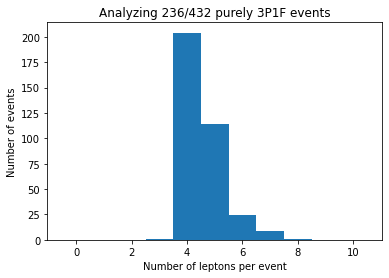

In [24]:
fig, ax = plt.subplots(1, 1)
bin_vals, bin_edges, _ = ax.hist(data, bins=range(0,12), align='left')
ax.set_xlabel(r'Number of leptons per event')
ax.set_ylabel(r'Number of events')
ax.set_title(f'Analyzing 236/432 purely 3P1F events')

In [ ]:
# cr_counts = Counter([tuple(sorted(v)) for v in elisa_3p1f_unique_evtid_dct.values()])
# df = pd.DataFrame.from_dict(cr_counts, orient='index')
# df.plot(kind='bar', legend=False, figsize=(12,9), grid=True, logy=False, fontsize=20, tick)

cr_counts

In [ ]:
n_tot_uniq = len(elisa_3p1f_unique_ls_tup)
n_tot_cjlst = t_matteo.GetEntries()
elisa_3p1f_unique_evtid_dct = {}

for unique_evt_num, evt_id in enumerate(elisa_3p1f_unique_ls_tup[:1], 1):
    if (unique_evt_num % 1) == 0:
        print(f"Searching for Elisa's unique event {unique_evt_num}/{n_tot_uniq}: {evt_id}")
    cr_ls = []
    run   = evt_id[0]
    lumi  = evt_id[1]
    event = evt_id[2]
    new_key = f"{run} : {lumi} : {event}"
    for cjlst_evt_num, cjlst_evt in enumerate(t_matteo):
        if (cjlst_evt_num % 10000) == 0:
            print(f"Scanning CJLST TTree for matching entry: {cjlst_evt_num}/{n_tot_cjlst}")
        if (run != cjlst_evt.RunNumber):
            continue
        if (lumi != cjlst_evt.LumiNumber):
            continue
        if (event != cjlst_evt.EventNumber):
            continue
        print(f"EVENT FOUND! Entry number: {cjlst_evt_num}")
        cr_ls.extend([CjlstFlag(cjlst_evt.CRflag).name])
    # cr_ls = [CjlstFlag(evt.CRflag).name for evt in t_matteo if (run == evt.RunNumber) and (lumi == evt.LumiNumber) and (event == evt.EventNumber)]
    elisa_3p1f_unique_evtid_dct[new_key] = cr_ls
pprint(elisa_3p1f_unique_evtid_dct)

In [ ]:
evt_id_ls_matteo = [(evt.RunNumber, evt.LumiNumber, evt.EventNumber,) for evt in t_matteo]
len(evt_id_ls_matteo) - len(set(evt_id_ls_matteo))
counter = Counter(evt_id_ls_matteo)
# pprint(list(counter.values())[:5])
dup_key_ls = [(k, ct) for k,ct in counter.items() if k == (315488, 152, 135937874,)]

evt_id_tup = (315488, 152, 135937874, )
counter[evt_id_tup]

### Find how many of CJLST RedBkg events contain exactly 4 leps:

In [ ]:
###############
#--- CJLST ---#
###############
n_tot = t_matteo.GetEntries()
redbkg_CRs = [flag.name for flag in CjlstFlag]
cr_flag_ls_cjlst = []

print("Finding all events in CJLST file with 4 leps per event.")
for evt_num, evt in enumerate(t_matteo):
    if (evt_num % 10000) == 0:
        print(f"Event {evt_num}/{n_tot}")
    n_reco_ele = evt.NRecoEle
    n_reco_mu  = evt.NRecoMu
    if (n_reco_ele + n_reco_mu) != 4:
        continue
    cr_flag_ls_cjlst.extend([evt.CRflag])
# Count occurrence of each CR:
print(f"Number of events with 4 leps: {len(cr_flag_ls_cjlst)}")
cr_flag_cntr_cjlst = Counter(cr_flag_ls_cjlst)
pprint([(CjlstFlag(k).name, ct) for k, ct in cr_flag_cntr_cjlst.items()])

In [ ]:
#############
#--- BBF ---#
#############
n_tot = t_jake.GetEntries()
redbkg_CRs = [flag.name for flag in CjlstFlag]
cr_flag_ls_bbf = []
evts_to_investigate = []

print("Finding all events in BBF file with 4 leps per event.")
for evt_num, evt in enumerate(t_jake):
    if (evt_num % 5000) == 0:
        print(f"Event {evt_num}/{n_tot}")
    if len(evt.lep_pt) != 4:
        continue
    cr_flag_ls_bbf.extend([get_control_region(evt)])

    if sum(list(evt.lep_tightId)) >= 4:
        evts_to_investigate.extend([evt_num])
# Count occurrence of each CR:
print(f"Number of events with 4 leps: {len(cr_flag_ls_bbf)}")
cr_flag_cntr_bbf = Counter(cr_flag_ls_bbf)
pprint([(k, ct) for k, ct in cr_flag_cntr_bbf.items()])

### What the heck? I've found events with `passedZXCRSelection == 1` but with exactly 4 tight leps...

#### We must also keep in mind the RelIso!

Let's investigate the originally-produced data files:

In [ ]:
infile_muonEG2018 = "/cmsuf/data/store/user/t2/users/rosedj1/HiggsMassMeasurement/Samples/skim2L/Data/2018/fullstats/MuonEG.root"
f_muonEG2018 = TFile(infile_muonEG2018)
t_muonEG2018 = f_muonEG2018.Get("Ana/passedEvents")
t_muonEG2018.GetEntries()  # 5228705.
t_muonEG2018.GetEntries("passedZXCRSelection==1")  # 8363.
t_muonEG2018.GetEntries("passedZXCRSelection==1 && Sum$(lep_tightId) == 4 && Length$(lep_pt) == 4")  # 353.
# Comparing per-element of a vector - Filippo suggests: &Lep_pt[0]

# weird_tightId_ls = [] 
# for evt_num, evt in enumerate(t_muonEG2018):
#     if () == 0: print(f"")
#     if not evt.passedZXCRSelection: continue 
#     tightId_ls = list(evt.lep_tightId) 
#     if len(tightId_ls) != 4: continue 
#     if sum(tightId_ls) != 4: continue 
#     weird_tightId_ls.extend([evt_num]) 

## How many tight leptons are there per event?

In [11]:
import numpy as np
from ROOT import TFile, TCanvas, TPaveText, gStyle, gPad
from Utils_ROOT.ROOT_classes import make_TH2F
from Utils_ROOT.Printer import CanvasPrinter
from Utils_Python.Plot_Styles_ROOT.tdrstyle_official import setTDRStyle, tdrGrid, fixOverlay
# =============================================================================
def normalize_TH2_per_column(h2):
    """Return a new TH2F with cells normalized to sum(cols) in which the cell
    is found.
    
    NOTE:
    - Doesn't affect under/overflow bins.
    - Errors should be handled more properly.
    """
    h2_norm = h2.Clone()
    h2_norm.Reset()
    # Go column by column and get the integral:
    nx_bins = h2.GetNbinsX()
    ny_bins = h2.GetNbinsY()
    for x_bin in range(1, nx_bins+1):
        proj_y = h2.ProjectionY(f"proj_y_{x_bin}", x_bin, x_bin)
        integ = proj_y.Integral()
        del proj_y
        if integ == 0:
            # Column completely empty.
            continue
        # Scale each cell in this column by the integral:
        y_sum = 0
        for y_bin in range(1, ny_bins+1):
            glob_bin = h2.GetBin(x_bin, y_bin)
            val = h2.GetBinContent(glob_bin)
            err = h2.GetBinError(glob_bin)
            fill_val = val / float(integ)
            fill_val_err = err / float(integ)
            h2_norm.SetBinContent(glob_bin, fill_val)
            h2_norm.SetBinError(glob_bin, fill_val_err)
    return h2_norm

def make_pave_with_stats(h2, xmin=0.15, ymin=0.8, xmax=0.4, ymax=0.9):
    """Return a TPave with simple stats located at (xmin, ymin, xmax, ymax)."""
    pave = TPaveText(xmin, ymin, xmax, ymax, "NDC")  # NDC = normalized coord.
    pave.SetFillColor(0)
    pave.SetFillStyle(1001)  # Solid fill.
    pave.SetBorderSize(1) # Use 0 for no border.
    pave.SetTextAlign(11)
    pave.SetTextSize(0.02)
    pave.AddText(f"Entries: {h2.GetEntries():.3f}")
    pave.AddText(f"Integral: {h2.Integral():.3f}")
    # pave.Draw("same")
    return pave

In [7]:
f_filippo_data2018 = TFile.Open("/cmsuf/data/store/user/t2/users/rosedj1/HiggsMassMeasurement/Samples/skim2L/Data/2018/fullstats/filippo/Data_2018_03Nov.root")
t_filippo_data2018 = f_filippo_data2018.Get("passedEvents")

In [15]:
# ===============================================================================
z_min = 0
z_max = 5.5E6
x_label = r"Number of leptons per event"

h2_ntightleps_vs_ntotleps = make_TH2F("h2_ntightleps_vs_ntotleps", title="Number of events with tight vs. total leptons", 
              n_binsx=10, x_label=x_label,
              x_units=None, x_min=2, x_max=12,
              n_binsy=8, y_label=r"Number of #bf{tight} leptons per event",
              y_units=None, y_min=0, y_max=8,
              z_min=z_min, z_max=z_max, z_label_size=None,
              n_contour=100)
              
h2_ntightandIsoleps_vs_ntotleps = make_TH2F("h2_ntightandIsoleps_vs_ntotleps", title="Number of events with (tight & isolated) vs. total leptons", 
              n_binsx=10, x_label=x_label,
              x_units=None, x_min=2, x_max=12,
              n_binsy=8, y_label=r"Number of #bf{tight and isolated} leptons per event",
              y_units=None, y_min=0, y_max=8,
              z_min=z_min, z_max=z_max, z_label_size=None,
              n_contour=100)

n_tot_entries = t_filippo_data2018.GetEntries()
for ct, evt in enumerate(t_filippo_data2018):
    if (ct % 500000) == 0:
        print(f"Event {ct}/{n_tot_entries}")

    lep_ls_id = list(evt.lep_id)
    lep_ls_tightId = list(evt.lep_tightId)
    lep_ls_RelIsoNoFSR = list(evt.lep_RelIsoNoFSR)
    n_tot_leps = len(lep_ls_id)

    # Check to see if each lepton is tight:
    n_tightId_per_event = 0
    n_tightId_and_RelIso_per_event = 0
    for ndx in range(n_tot_leps):
        is_tight = lep_ls_tightId[ndx]
        if is_tight:
            n_tightId_per_event += 1

            # If we have a muon, see if it passed RelIso:
            if abs(lep_ls_id[ndx]) == 13:
                if lep_ls_RelIsoNoFSR[ndx] < 0.35:
                    n_tightId_and_RelIso_per_event += 1

    h2_ntightleps_vs_ntotleps.Fill(n_tot_leps, n_tightId_per_event, 1)
    h2_ntightandIsoleps_vs_ntotleps.Fill(n_tot_leps, n_tightId_and_RelIso_per_event, 1)

    # if ct > 10000: break

outpdf_path = "/cmsuf/data/store/user/t2/users/rosedj1/HiggsMassMeasurement/Samples/skim2L/Data/2018/fullstats/filippo/test/test03_th2f_totalleps_vs_tightleps.pdf"

hist_ls = [h2_ntightleps_vs_ntotleps, h2_ntightandIsoleps_vs_ntotleps]

canv = TCanvas()
style = setTDRStyle(pad_right_margin=0.15)
gStyle.SetPaintTextFormat(".3g")
gStyle.SetOptStat(0)

canv.Print(outpdf_path + "[")
for h2 in hist_ls:
    h2.GetXaxis().CenterLabels()
    h2.GetYaxis().CenterLabels()
    h2.UseCurrentStyle()
    h2.Draw("colz text")
    gPad.Update()
    pave = make_pave_with_stats(h2, xmin=0.15, ymin=0.8, xmax=0.4, ymax=0.9)
    pave.Draw("same")
    # statsbox = h2.FindObject("stats")
    # statsbox.SetX1NDC(0.55)
    # statsbox.SetX2NDC(0.8)
    # statsbox.SetY1NDC(0.8)
    # statsbox.SetY2NDC(0.9)
    canv.Print(outpdf_path)
canv.Print(outpdf_path + "]")

Event 0/8094112
Event 500000/8094112
Event 1000000/8094112
Event 1500000/8094112
Event 2000000/8094112
Event 2500000/8094112
Event 3000000/8094112
Event 3500000/8094112
Event 4000000/8094112
Event 4500000/8094112
Event 5000000/8094112
Event 5500000/8094112
Event 6000000/8094112
Event 6500000/8094112
Event 7000000/8094112
Event 7500000/8094112
Event 8000000/8094112
Warning in <TFile::Append>: Replacing existing TH1: h2_ntightleps_vs_ntotleps (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h2_ntightandIsoleps_vs_ntotleps (Potential memory leak).
Info in <TCanvas::Print>: pdf file /cmsuf/data/store/user/t2/users/rosedj1/HiggsMassMeasurement/Samples/skim2L/Data/2018/fullstats/filippo/test/test03_th2f_totalleps_vs_tightleps.pdf has been created
Info in <TCanvas::Print>: Current canvas added to pdf file /cmsuf/data/store/user/t2/users/rosedj1/HiggsMassMeasurement/Samples/skim2L/Data/2018/fullstats/filippo/test/test03_th2f_totalleps_vs_tightleps.pdf
Info in <TCanv

In [16]:
#############################################
#--- Save precious hists in a root file. ---#
#############################################
outrootfile = outpdf_path.replace(".pdf", "_nleps2to12.root")
f_new = TFile.Open(outrootfile, "recreate")
h2_ntightleps_vs_ntotleps.Write()
h2_ntightandIsoleps_vs_ntotleps.Write()
f_new.Close()

In [8]:
#--- Restore hists ---#
f_hists = TFile("/cmsuf/data/store/user/t2/users/rosedj1/HiggsMassMeasurement/Samples/skim2L/Data/2018/fullstats/filippo/th2f_totalleps_vs_tightleps.root", "read")
h2_ntightleps_vs_ntotleps = f_hists.Get("h2_ntightleps_vs_ntotleps")
h2_ntightandIsoleps_vs_ntotleps = f_hists.Get("h2_ntightandIsoleps_vs_ntotleps")

In [18]:
#--- Convert to percent of all entries in TH2. ---#
h2_ntightleps_vs_ntotleps_perc = h2_ntightleps_vs_ntotleps.Clone()
h2_ntightleps_vs_ntotleps_perc.Scale(100.0/h2_ntightleps_vs_ntotleps.Integral())
title = h2_ntightleps_vs_ntotleps_perc.GetTitle()
h2_ntightleps_vs_ntotleps_perc.SetTitle(f"{title} (as % of total integral)")

h2_ntightandIsoleps_vs_ntotleps_perc = h2_ntightandIsoleps_vs_ntotleps.Clone()
h2_ntightandIsoleps_vs_ntotleps_perc.Scale(100.0/h2_ntightandIsoleps_vs_ntotleps.Integral())
title = h2_ntightandIsoleps_vs_ntotleps_perc.GetTitle()
h2_ntightandIsoleps_vs_ntotleps_perc.SetTitle(f"{title} (as % of total integral)")

#--- Already normalized per column so just convert to a percentage. ---#
h2_norm_ntightleps_vs_ntotleps = normalize_TH2_per_column(h2_ntightleps_vs_ntotleps)
h2_norm_ntightleps_vs_ntotleps_perc = h2_norm_ntightleps_vs_ntotleps.Clone()
h2_norm_ntightleps_vs_ntotleps_perc.Scale(100.0)
title = h2_norm_ntightleps_vs_ntotleps_perc.GetTitle()
h2_norm_ntightleps_vs_ntotleps_perc.SetTitle(f"{title} (as % of total column)")


h2_norm_ntightandIsoleps_vs_ntotleps = normalize_TH2_per_column(h2_ntightandIsoleps_vs_ntotleps)
h2_norm_ntightandIsoleps_vs_ntotleps_perc = h2_norm_ntightandIsoleps_vs_ntotleps.Clone()
h2_norm_ntightandIsoleps_vs_ntotleps_perc.Scale(100.0)
title = h2_norm_ntightandIsoleps_vs_ntotleps_perc.GetTitle()
h2_norm_ntightandIsoleps_vs_ntotleps_perc.SetTitle(f"{title} (as % of total column)")

#--- Final hists from here: ---#
# h2_ntightleps_vs_ntotleps_perc, h2_ntightandIsoleps_vs_ntotleps_perc
# h2_norm_ntightleps_vs_ntotleps_perc, h2_norm_ntightandIsoleps_vs_ntotleps_perc


In [24]:
outpdf_path = "/cmsuf/data/store/user/t2/users/rosedj1/HiggsMassMeasurement/Samples/skim2L/Data/2018/fullstats/filippo/test/allth2_totalleps_vs_tightleps_formatp2g.pdf"
markersize = 0.8  # 0.1, 0.01
# printer = CanvasPrinter()
# printer.make_plots_pretty(show_statsbox=False)

# style = setTDRStyle(pad_right_margin=0.15)
style = setTDRStyle()
style.cd()
style.SetPadRightMargin(0.15)

canv = TCanvas()
gStyle.SetOptStat(0)

canv.Print(outpdf_path + "[")
for h in (h2_ntightleps_vs_ntotleps, h2_ntightandIsoleps_vs_ntotleps):
    gStyle.SetPaintTextFormat(".2g")
    h.UseCurrentStyle()
    h.SetMarkerSize(markersize)
    h.GetZaxis().SetRangeUser(0, 5.5E6)
    h.Draw("colz text")
    pave = make_pave_with_stats(h, xmin=0.15, ymin=0.8, xmax=0.4, ymax=0.9)
    pave.Draw("same")
    # statsbox = h.FindObject("stats")
    # statsbox.SetX1NDC(0.55)
    # statsbox.SetX2NDC(0.8)
    # statsbox.SetY1NDC(0.8)
    # statsbox.SetY2NDC(0.9)
    # h.Draw("lego")
    # canv.Update()
    # gPad.RedrawAxis()
    # canv.RedrawAxis()
    canv.Print(outpdf_path)

for h in (h2_ntightleps_vs_ntotleps_perc, h2_ntightandIsoleps_vs_ntotleps_perc):
    # h.SetTitle(h.GetTitle().rstrip(" (%)"))
    # h.SetTitle(f"{h.GetTitle()} (%)")
    # h.SetTitle(f"{h.GetTitle()} (%)")
    gStyle.SetPaintTextFormat(".2g%%")
    h.SetMarkerSize(markersize)
    h.GetZaxis().SetRangeUser(0, 85.0)
    h.Draw("colz text")
    pave = make_pave_with_stats(h, xmin=0.15, ymin=0.8, xmax=0.4, ymax=0.9)
    pave.Draw("same")
    # statsbox = h.FindObject("stats")
    # statsbox.SetX1NDC(0.55)
    # statsbox.SetX2NDC(0.8)
    # statsbox.SetY1NDC(0.8)
    # statsbox.SetY2NDC(0.9)
    # h.Draw("lego")
    canv.Print(outpdf_path)

for h in (h2_norm_ntightleps_vs_ntotleps_perc, h2_norm_ntightandIsoleps_vs_ntotleps_perc):
    # h.SetTitle(h.GetTitle().rstrip(" (%)"))
    # h.SetTitle(f"{h.GetTitle()} (%)")
    # h.SetTitle(f"{h.GetTitle()} (%)")
    gStyle.SetPaintTextFormat(".2g%%")
    h.SetMarkerSize(markersize)
    h.GetZaxis().SetRangeUser(0, 100.0)
    h.Draw("colz text")
    pave = make_pave_with_stats(h, xmin=0.15, ymin=0.8, xmax=0.4, ymax=0.9)
    pave.Draw("same")
    # statsbox = h.FindObject("stats")
    # statsbox.SetX1NDC(0.55)
    # statsbox.SetX2NDC(0.8)
    # statsbox.SetY1NDC(0.8)
    # statsbox.SetY2NDC(0.9)
    # h.Draw("lego")
    canv.Print(outpdf_path)
canv.Print(outpdf_path + "]")

Info in <TCanvas::Print>: pdf file /cmsuf/data/store/user/t2/users/rosedj1/HiggsMassMeasurement/Samples/skim2L/Data/2018/fullstats/filippo/test/allth2_totalleps_vs_tightleps_formatp2g.pdf has been created
Info in <TCanvas::Print>: Current canvas added to pdf file /cmsuf/data/store/user/t2/users/rosedj1/HiggsMassMeasurement/Samples/skim2L/Data/2018/fullstats/filippo/test/allth2_totalleps_vs_tightleps_formatp2g.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file /cmsuf/data/store/user/t2/users/rosedj1/HiggsMassMeasurement/Samples/skim2L/Data/2018/fullstats/filippo/test/allth2_totalleps_vs_tightleps_formatp2g.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file /cmsuf/data/store/user/t2/users/rosedj1/HiggsMassMeasurement/Samples/skim2L/Data/2018/fullstats/filippo/test/allth2_totalleps_vs_tightleps_formatp2g.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file /cmsuf/data/store/user/t2/users/rosedj1/HiggsMassMeasurement/Samples/skim2L/Data/2018/fullstats/fili